In [1]:
import re

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st

import pymc as pm
import hddm

from patsy import dmatrix

/home/c1745595/miniconda3/envs/hddm/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [2]:
plt.rcParams.update({'font.size': 14})
#import matplotlib as mpl
#mpl.rcParams['axes.spines.right'] = False
#mpl.rcParams['axes.spines.top'] = False

In [37]:
def _parents_to_random_posterior_sample(bottom_node, pos=None):
    """Walks through parents and sets them to pos sample."""
    for i, parent in enumerate(bottom_node.extended_parents):
        if not isinstance(parent, pm.Node): # Skip non-stochastic nodes
            continue

        if pos is None:
            # Set to random posterior position
            pos = np.random.randint(0, len(parent.trace()))

        assert len(parent.trace()) >= pos, "pos larger than posterior sample size"
        parent.value = parent.trace()[pos]

def plot_posterior_pdf_node(bottom_node, axis = None, value_range=np.linspace(-5, 5, 100),
                            samples=10, bins=100, color = '#3296fa'):
    """Calculate posterior predictive for a certain bottom node.
    :Arguments:
        bottom_node : pymc.stochastic
            Bottom node to compute posterior over.
        axis : matplotlib.axis
            Axis to plot into.
        value_range : numpy.ndarray
            Range over which to evaluate the likelihood.
    :Optional:
        samples : int (default=10)
            Number of posterior samples to use.
        bins : int (default=100)
            Number of bins to compute histogram over.
    """
    like = np.empty((samples, len(value_range)), dtype=np.float32)
    for sample in range(samples):
        _parents_to_random_posterior_sample(bottom_node)
        # Generate likelihood for parents parameters
        like[sample,:] = bottom_node.pdf(value_range)

    y = like.mean(axis=0)
    try:
        y_std = like.std(axis=0)
    except FloatingPointError:
        print("WARNING! %s threw FloatingPointError over std computation. Setting to 0 and continuing." % bottom_node.__name__)
        y_std = np.zeros_like(y)
    if axis is None:
        axis = plt
    # Plot pp
    axis.plot(value_range, y, label='post pred', color='k')
    axis.fill_between(value_range, y-y_std, y+y_std, color='k', alpha=.8)

    # Plot data
    if len(bottom_node.value) != 0:
        axis.hist(bottom_node.value.values, density=True, color=color,
                  range=(value_range[0], value_range[-1]), label='data',
                  bins=bins, histtype='step', lw=2.)
    if not hasattr(axis, 'set_ylim'):
        axis.ylim(bottom=0)
    else:
        axis.set_ylim(bottom=0) # Likelihood and histogram can only be positive

def plot_posterior_pdf_from_subject(model, condition, subject_idx, title = True, color = None):
    '''
    model - 
    condition - hashable object indicating specific condition-  [for example (20, 'C1')]
    subject_idx (int) - subject index
    '''
    obs = model.get_observeds()
    if subject_idx > model.num_subjs:
        raise ValueError('Subject index higher than expected')
    nodes = [n for _, n in obs.groupby('tag') if n.tag[0] == condition]
    if len(nodes) == 0:
        raise ValueError('No data found for condition, probably wrong condition?')
    node = nodes[0]
    node_per_subj = node.iloc[subject_idx]
    if color is None:
        plot_posterior_pdf_node(node_per_subj['node'])
    else:
        plot_posterior_pdf_node(node_per_subj['node'], color = color)
    if title:
        plt.title('Condtion: ' + str(condition))
        plt.suptitle('Participant: {}'.format(subject_idx))

        
def plot_posterior_nodes(nodes, bins=50, lb=None, ub=None,
                         leg = True, cols = None, linestyles = None):
    """Plot interpolated posterior of a list of nodes.
    :Arguments:
        nodes : list of pymc.Node's
            List of pymc.Node's to plot the posterior of.
            These can be found in model.nodes_db.node.loc['param_name']
        bins : int (default=50)
            How many bins to use for computing the histogram.
        lb : float (default is to infer from data)
            Lower boundary to use for plotting.
        ub : float (default is to infer from data)
            Upper boundary to use for plotting.
    """
    from kabuki.utils import interpolate_trace
    if lb is None:
        lb = min([min(node.trace()[:]) for node in nodes])
    if ub is None:
        ub = max([max(node.trace()[:]) for node in nodes])

    x_data = np.linspace(lb, ub, 300)
    _def_cols = ['r', 'b', 'g', 'm', 'y', 'k', 'o']
    for e, node in enumerate(nodes):
        trace = node.trace()[:]
        #hist = interpolate_trace(x_data, trace, range=(trace.min(), trace.max()), bins=bins)
        hist = interpolate_trace(x_data, trace, range=(lb, ub), bins=bins)
        if cols is None and linestyles is None:
            plt.plot(x_data, hist, label=node.__name__, lw=2.)
        else:
            col = _def_cols[e] if cols is None else cols[e]
            ls = '-' if linestyles is None else linestyles[e]
            plt.plot(x_data, hist, label=node.__name__, lw=2., ls=ls, color=col)
    
    
    if leg:
        leg = plt.legend(loc='best', fancybox=True)
        leg.get_frame().set_alpha(0.5)

## Data load

In [4]:
data = pd.read_csv('trials_all.csv')

In [5]:
data = data[data['rt'] != data['rt'].max()] # some strange outliers in the 45
data = data[data['rt'] != data['rt'].max()]
dataf = data[data['rt'] > 0]

,Unnamed: 0,rt,response,axes,cogr,condition,subj_idx,angle
0,0,2.384600,1,2.0,0.0,I2,0,20
1,1,1.960730,1,2.0,0.0,I2,0,20
3,3,1.857445,1,1.0,0.0,I1,0,20
4,4,-2.672745,0,2.0,1.0,C2,0,20
5,5,1.869880,1,2.0,0.0,I2,0,20


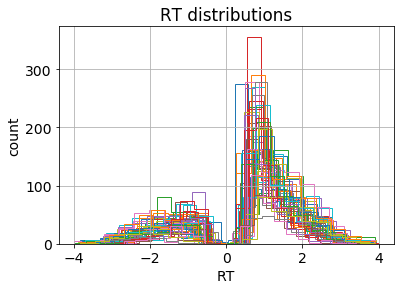

In [6]:
data = pd.read_csv('trials_all.csv')

data = data[data['rt'] != data['rt'].max()] # some strange outliers in the 45
data = data[data['rt'] != data['rt'].max()]
dataf = data[data['rt'] > 0]
dataf = dataf[~(dataf.rt<200)]

dataf = hddm.utils.flip_errors(dataf)
dataf.rt = dataf.rt/1000

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in dataf.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)
dataf.head()

# Load model

In [7]:
m = hddm.load('hddm_model_vta_no.ml')

# Make plots

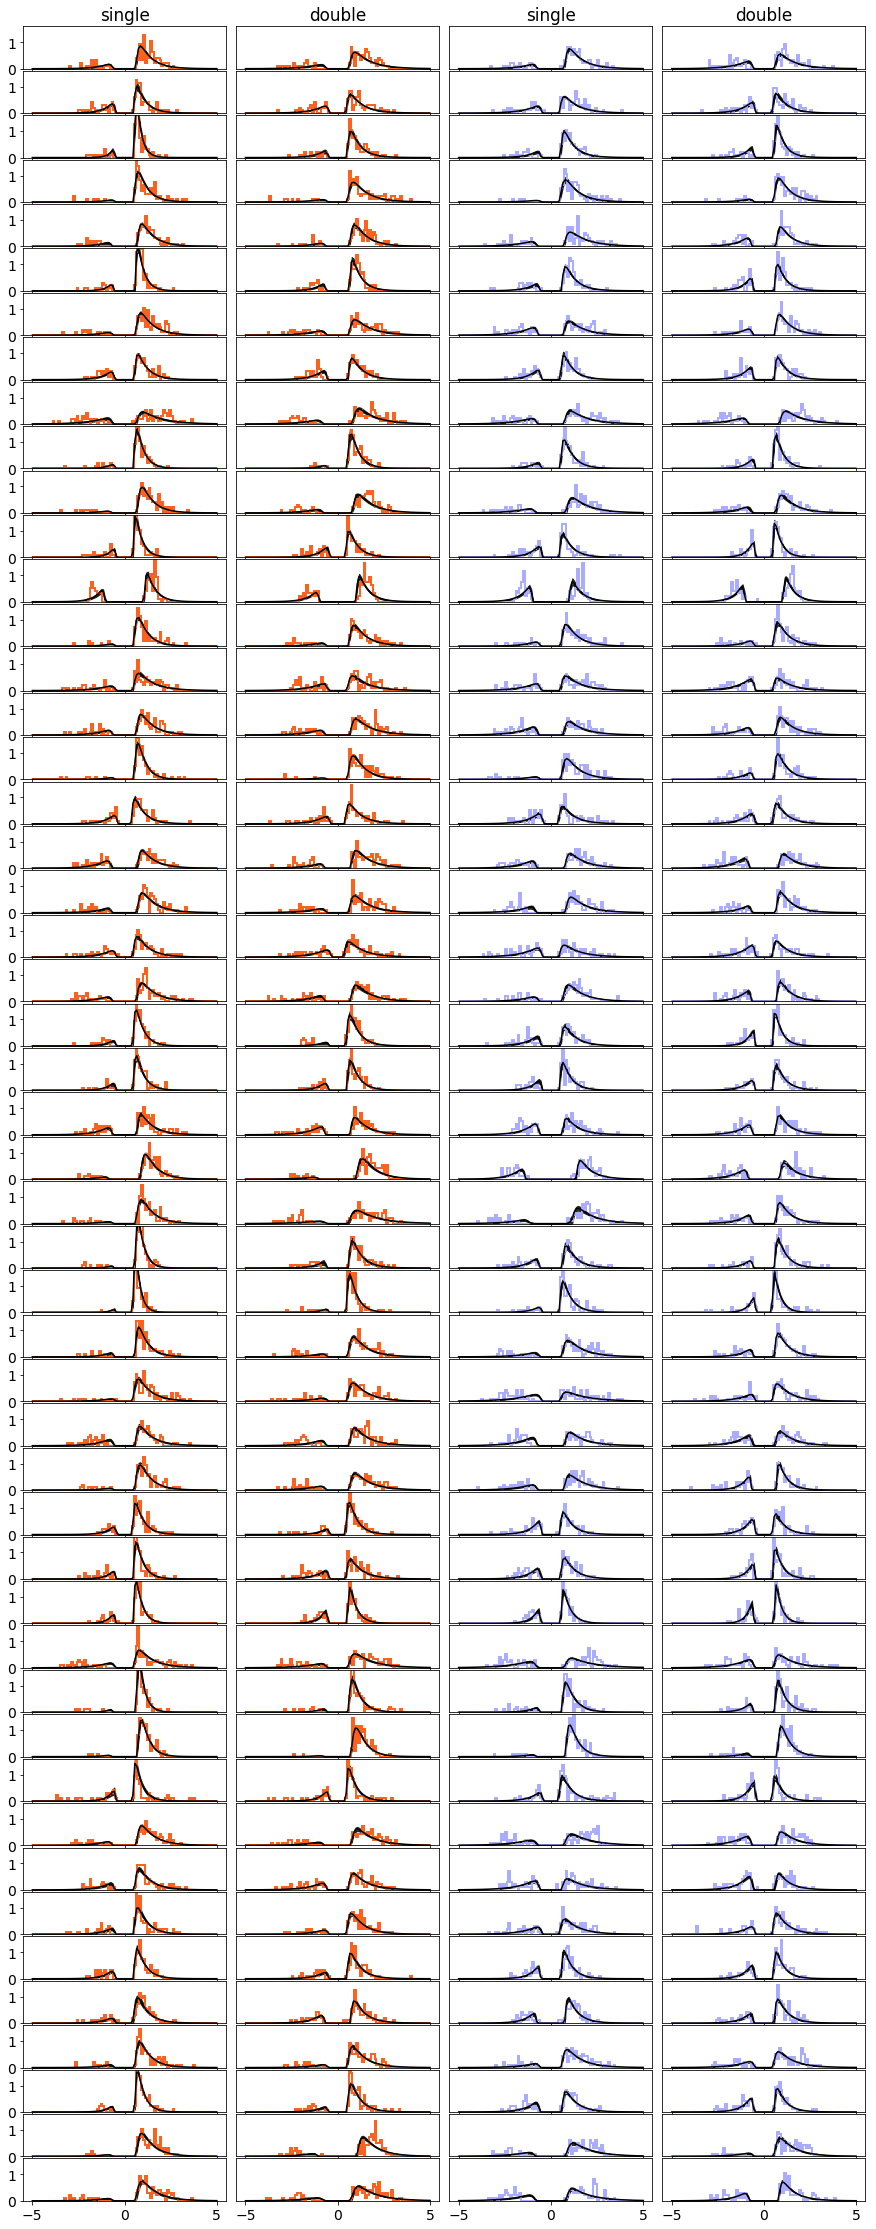

In [40]:
fig = plt.figure(figsize=(13, 40))
N_subj = 49

fig.subplots_adjust(left=0.05, right=0.95, hspace = 0.05, wspace = 0.05)

ii = 1
for subject in range(N_subj):    
    plt.subplot(N_subj,4,ii)
    plot_posterior_pdf_from_subject(m, (20, 'C1'), subject, title = False, color='#fb6220')
    plt.ylim([0, 1.6])
    if subject == 0: plt.title('single')
    #plt.ylabel('RT distribution [a.u.]')
    ii += 1
    plt.subplot(N_subj,4,ii)
    plot_posterior_pdf_from_subject(m, (20, 'C2'), subject, title = False, color='#fb6220')
    plt.ylim([0, 1.6])
    plt.yticks([])
    if subject == 0: plt.title('double')
    ii += 1
    plt.subplot(N_subj,4,ii)
    plot_posterior_pdf_from_subject(m, (20, 'I1'), subject, title = False, color='#aaacff')
    plt.ylim([0, 1.6])
    plt.yticks([])
    if subject == 0: plt.title('single')
    ii += 1
    plt.subplot(N_subj,4,ii)
    plot_posterior_pdf_from_subject(m, (20, 'I2'), subject, title = False, color='#aaacff')
    plt.ylim([0, 1.6])
    plt.yticks([])
    if subject == 0: plt.title('double')
    ii += 1
plt.savefig('rts_ind_plot_20.svg')

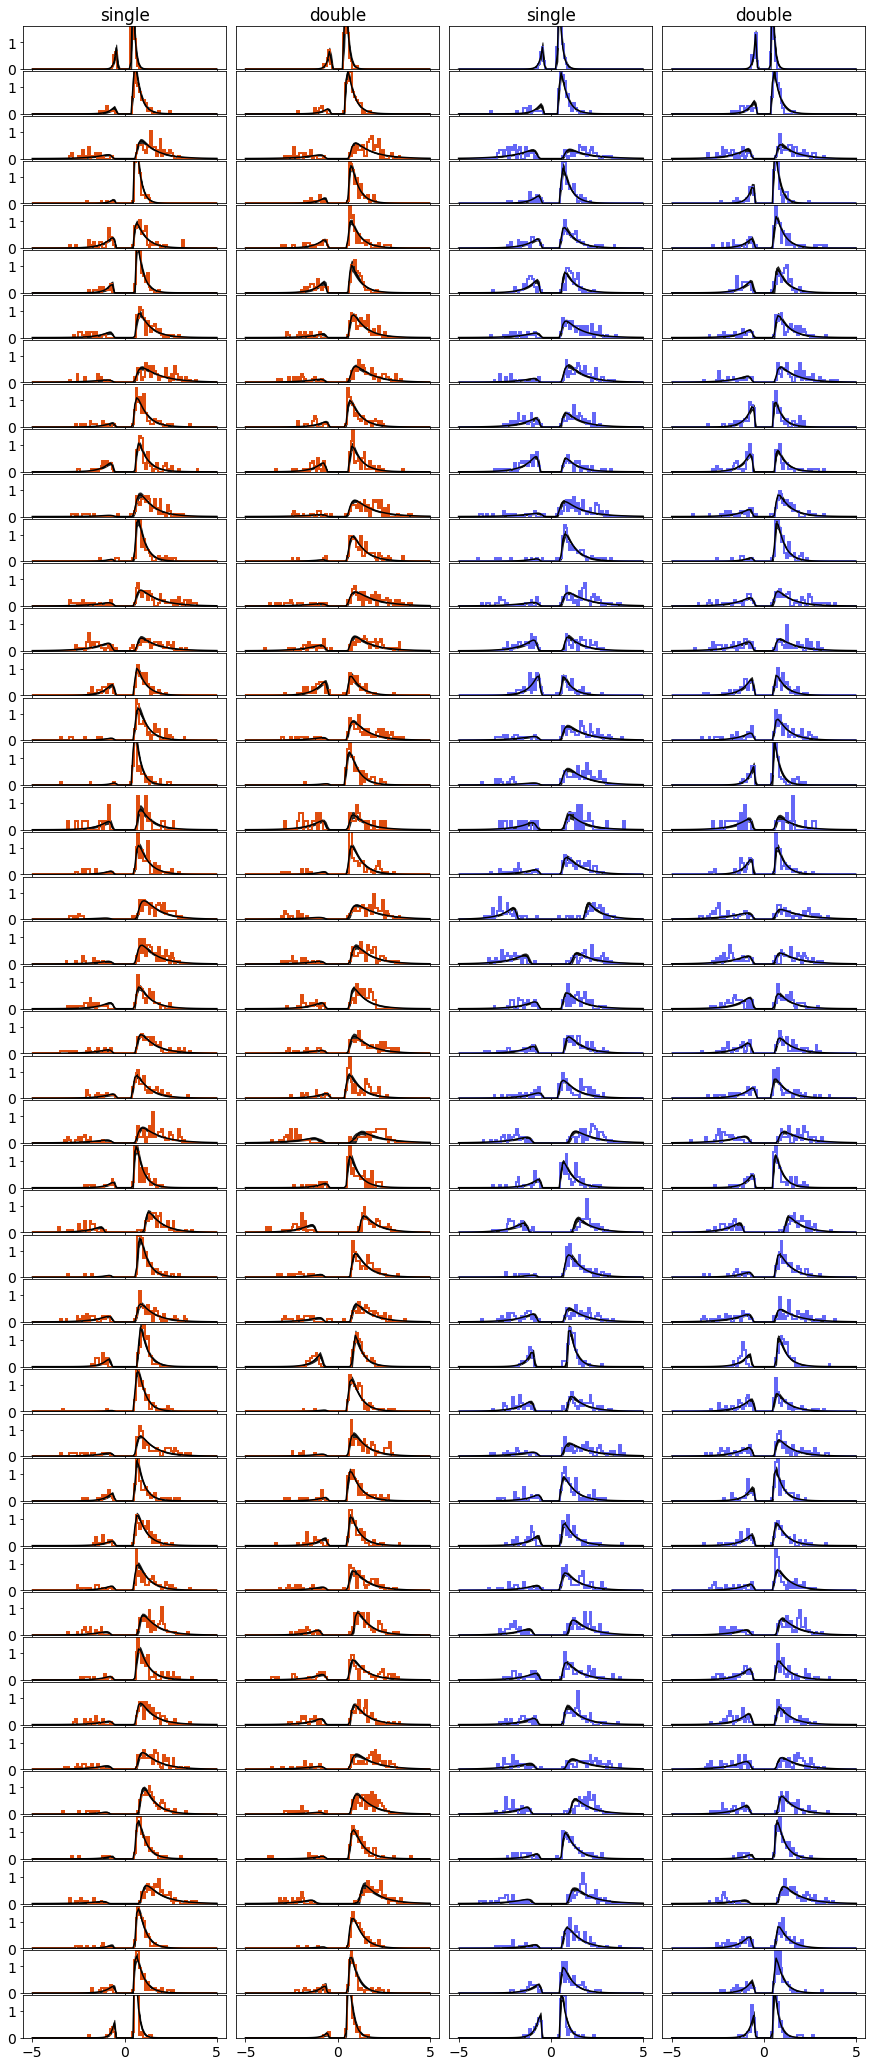

In [41]:
fig = plt.figure(figsize=(13, 37))
N_subj = 45

fig.subplots_adjust(left=0.05, right=0.95, hspace = 0.05, wspace = 0.05)

ii = 1
for subject in range(N_subj):    
    plt.subplot(N_subj,4,ii)
    plot_posterior_pdf_from_subject(m, (45, 'C1'), subject, title = False, color='#df4e0f')
    plt.ylim([0, 1.6])
    if subject == 0: plt.title('single')
    #plt.ylabel('RT distribution [a.u.]')
    ii += 1
    plt.subplot(N_subj,4,ii)
    plot_posterior_pdf_from_subject(m, (45, 'C2'), subject, title = False, color='#df4e0f')
    plt.ylim([0, 1.6])
    plt.yticks([])
    if subject == 0: plt.title('double')
    ii += 1
    plt.subplot(N_subj,4,ii)
    plot_posterior_pdf_from_subject(m, (45, 'I1'), subject, title = False, color='#6467f6')
    plt.ylim([0, 1.6])
    plt.yticks([])
    if subject == 0: plt.title('single')
    ii += 1
    plt.subplot(N_subj,4,ii)
    plot_posterior_pdf_from_subject(m, (45, 'I2'), subject, title = False, color='#6467f6')
    plt.ylim([0, 1.6])
    plt.yticks([])
    if subject == 0: plt.title('double')
    ii += 1
plt.savefig('rts_ind_plot_45.svg')

Plotting a(20.C1)
Plotting a(20.C2)
Plotting a(20.I1)
Plotting a(20.I2)
Plotting a(45.C1)
Plotting a(45.C2)
Plotting a(45.I1)
Plotting a(45.I2)
Plotting a_std
Plotting v(20.C1)
Plotting v(20.C2)
Plotting v(20.I1)
Plotting v(20.I2)
Plotting v(45.C1)
Plotting v(45.C2)
Plotting v(45.I1)
Plotting v(45.I2)
Plotting t(20.C1)
Plotting t(20.C2)
Plotting t(20.I1)
Plotting t(20.I2)
Plotting t(45.C1)
Plotting t(45.C2)


/home/c1745595/miniconda3/envs/hddm/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Plotting t(45.I1)
Plotting t(45.I2)


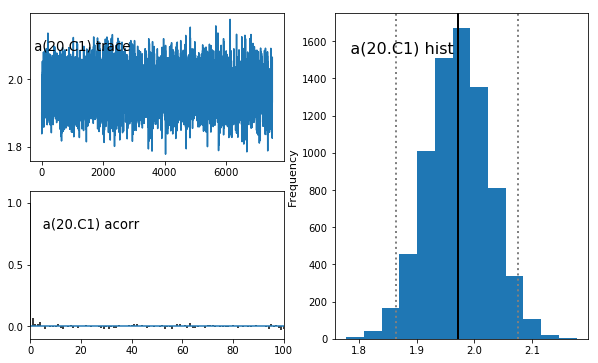

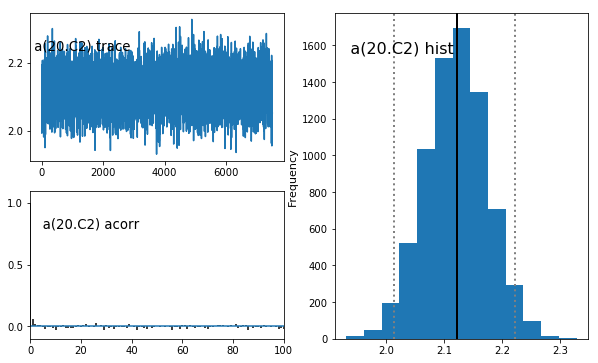

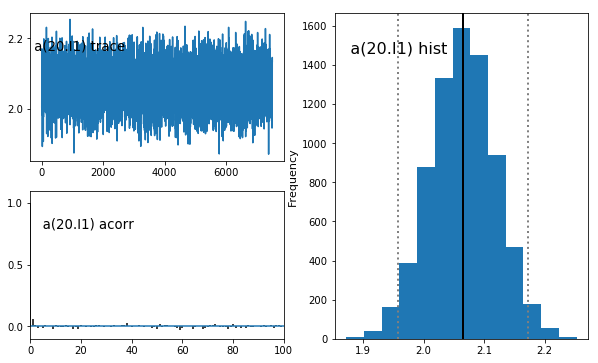

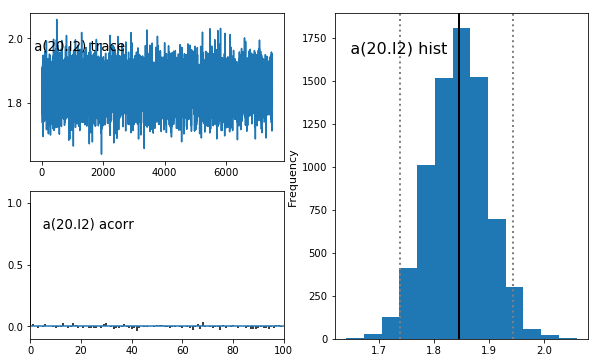

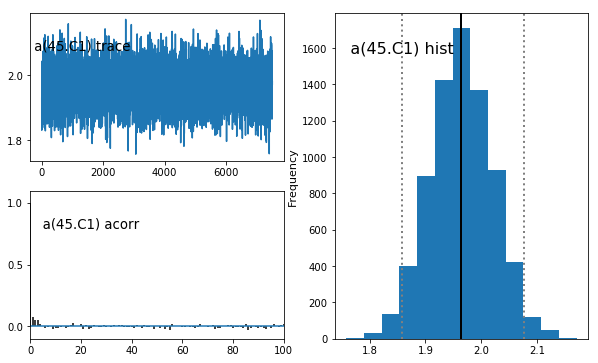

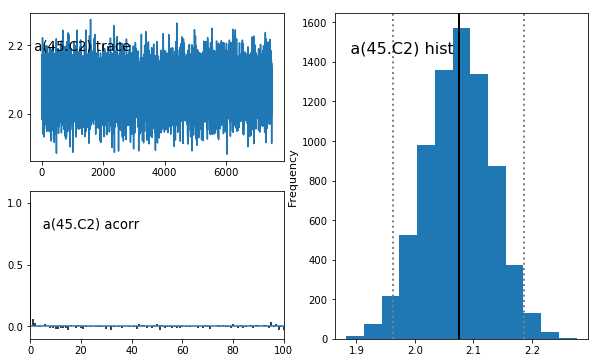

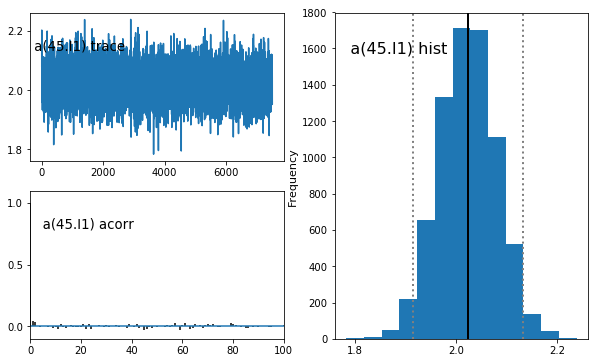

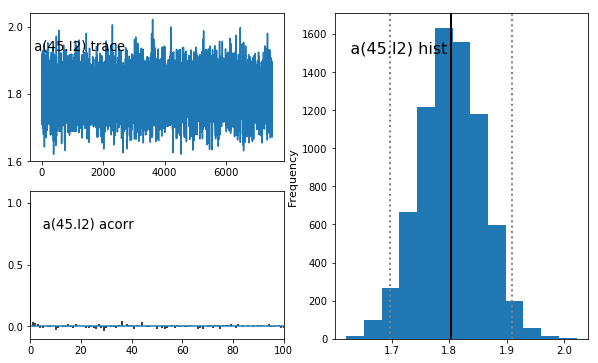

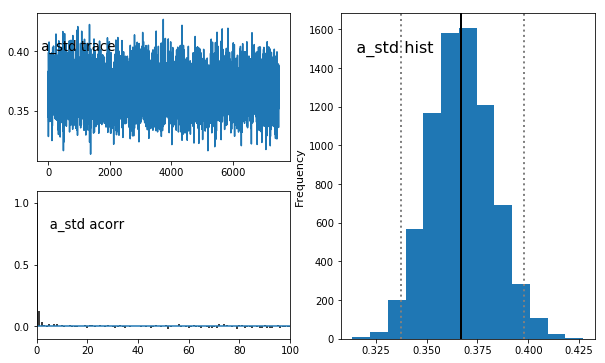

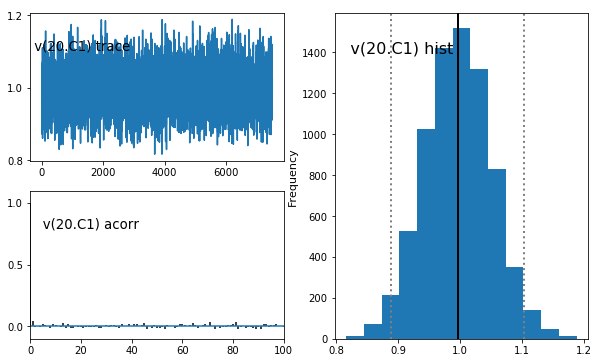

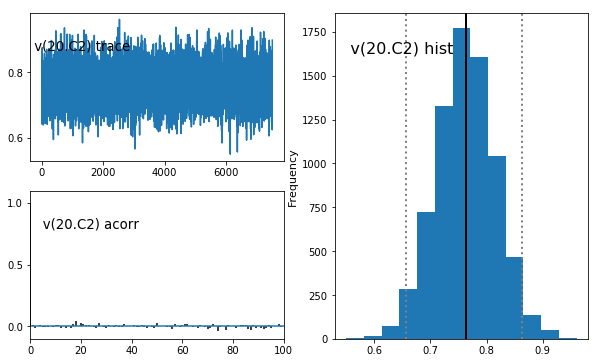

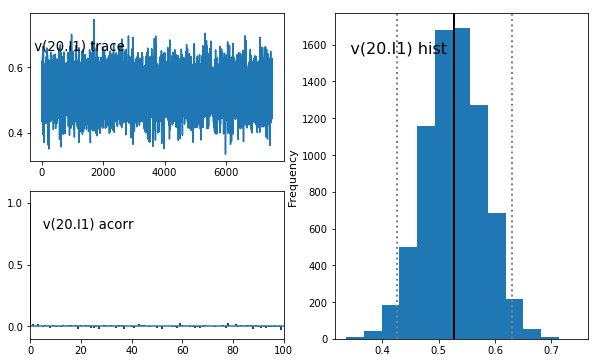

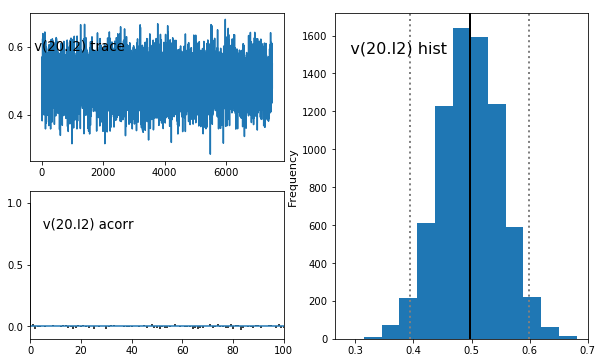

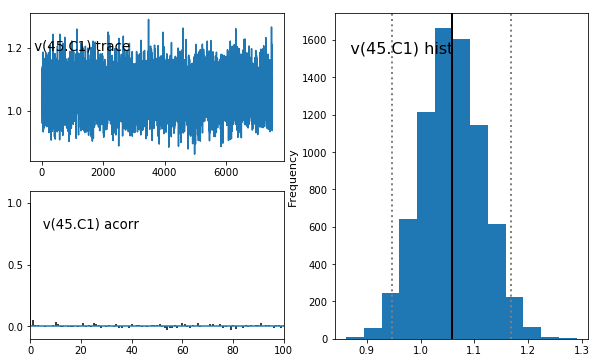

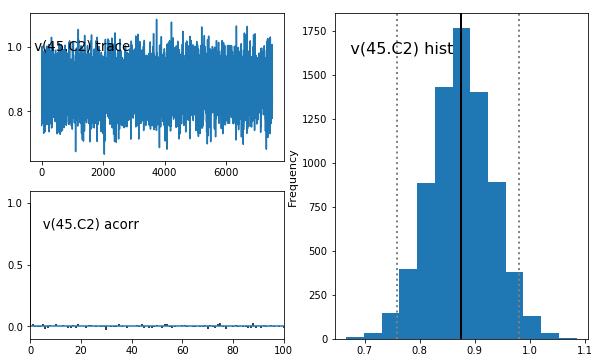

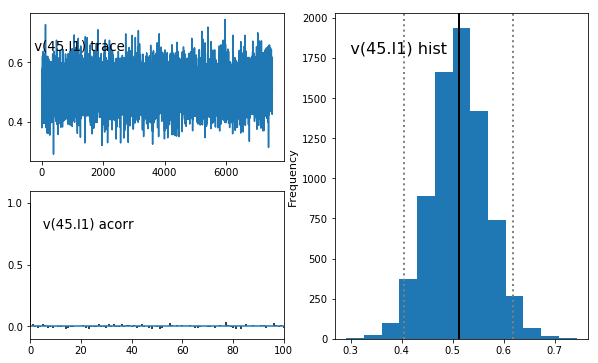

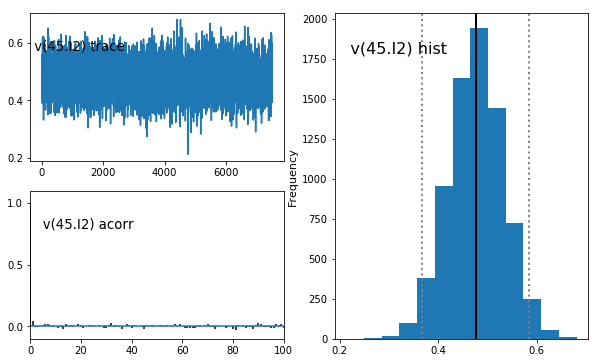

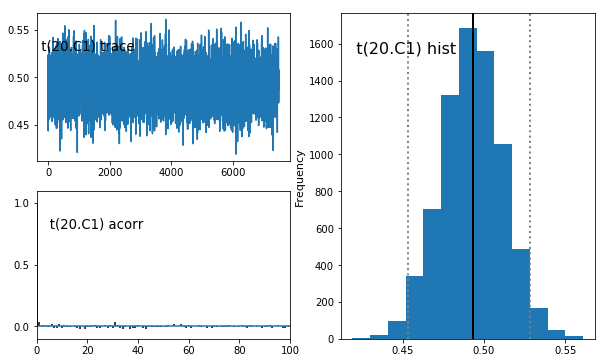

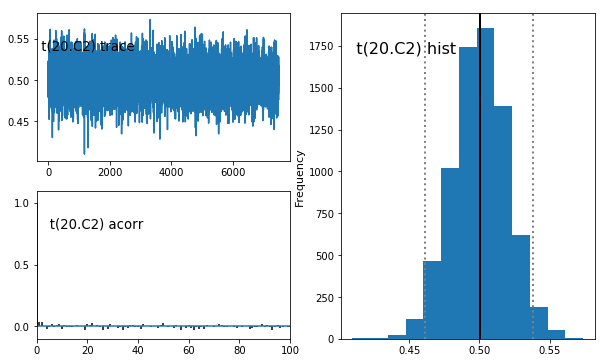

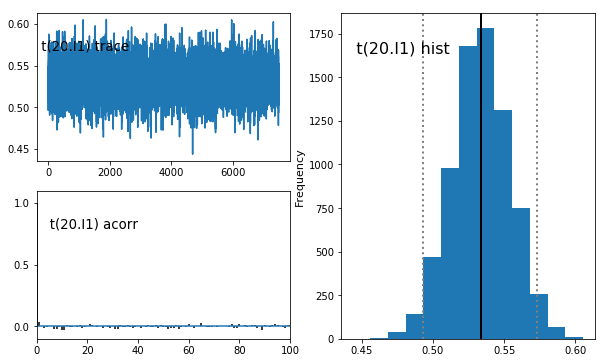

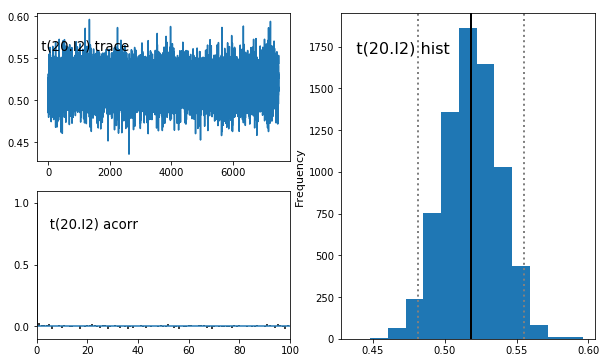

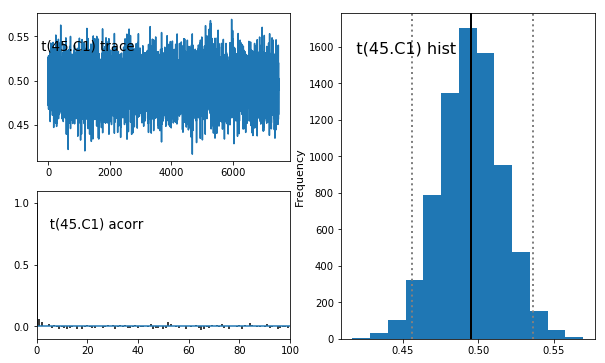

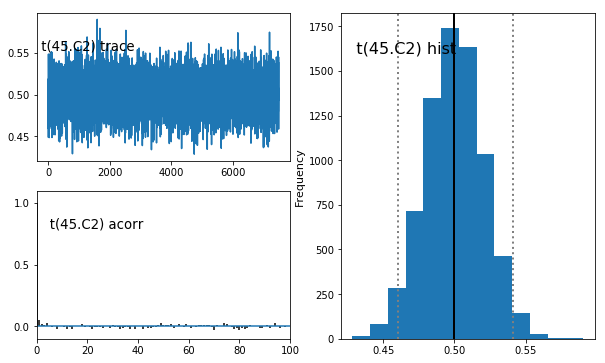

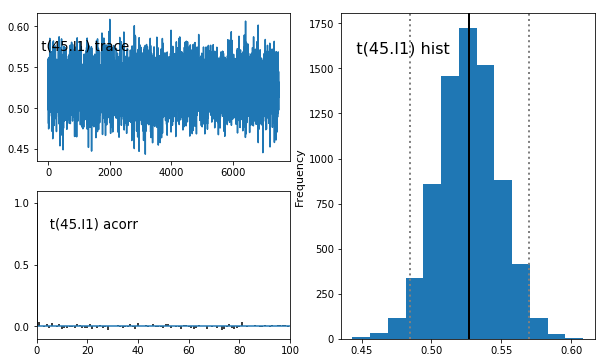

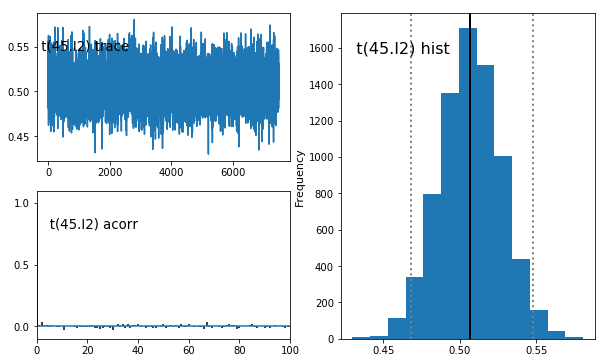

In [9]:
m.plot_posteriors(['a', 't', 'v', 'a_std'])

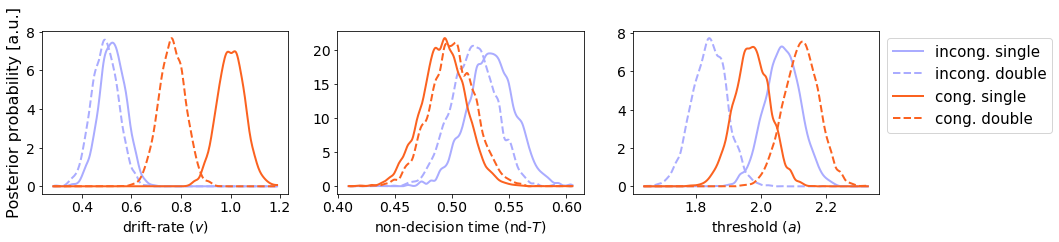

In [43]:
plt.figure(figsize = (15,3))
plt.subplot(131)
v_I1_20, v_I2_20, v_C1_20, v_C2_20 = m.nodes_db.node[['v(20.I1)', 'v(20.I2)', 'v(20.C1)', 'v(20.C2)']]
plot_posterior_nodes([v_I1_20, v_I2_20, v_C1_20, v_C2_20], leg = False,
                     cols = ['#aaacff', '#aaacff', '#fb6220','#fb6220'],
                     linestyles = ['-', '--', '-', '--'])
plt.xlabel('drift-rate ($v$)')
plt.ylabel('Posterior probability [a.u.]', fontsize = 16)

plt.subplot(132)
t_I1_20, t_I2_20, t_C1_20, t_C2_20 = m.nodes_db.node[['t(20.I1)', 't(20.I2)', 't(20.C1)', 't(20.C2)']]
plot_posterior_nodes([t_I1_20, t_I2_20, t_C1_20, t_C2_20], leg = False,
                     cols = ['#aaacff', '#aaacff', '#fb6220','#fb6220'],
                     linestyles = ['-', '--', '-', '--'])
plt.xlabel('non-decision time (nd-$T$)')

plt.subplot(133)
a_I1_20, a_I2_20, a_C1_20, a_C2_20 = m.nodes_db.node[['a(20.I1)', 'a(20.I2)', 'a(20.C1)', 'a(20.C2)']]
plot_posterior_nodes([a_I1_20, a_I2_20, a_C1_20, a_C2_20], leg = False,
                     cols = ['#aaacff', '#aaacff', '#fb6220','#fb6220'],
                     linestyles = ['-', '--', '-', '--'])
plt.xlabel('threshold ($a$)')
plt.legend(['incong. single', 'incong. double', 'cong. single', 'cong. double'],
           bbox_to_anchor=(1,1), loc="upper left",  prop={'size': 15})
plt.savefig('hddm_params.svg')
plt.show()

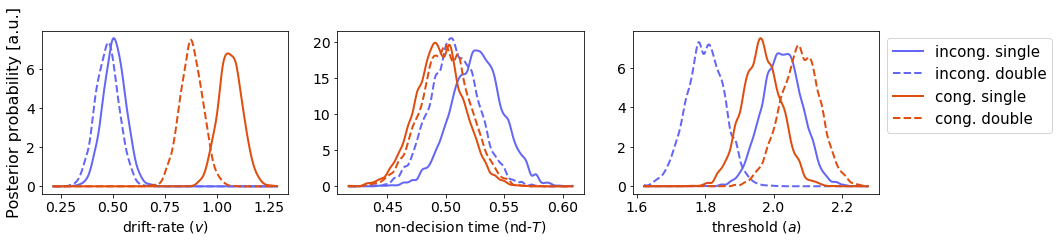

In [44]:
plt.figure(figsize = (15,3))
plt.subplot(131)
v_I1_45, v_I2_45, v_C1_45, v_C2_45 = m.nodes_db.node[['v(45.I1)', 'v(45.I2)', 'v(45.C1)', 'v(45.C2)']]
plot_posterior_nodes([v_I1_45, v_I2_45, v_C1_45, v_C2_45], leg = False,
                     cols = ['#6467f6', '#6467f6', '#df4e0f','#df4e0f'],
                     linestyles = ['-', '--', '-', '--'])
plt.xlabel('drift-rate ($v$)')
plt.ylabel('Posterior probability [a.u.]', fontsize = 16)

plt.subplot(132)
t_I1_45, t_I2_45, t_C1_45, t_C2_45 = m.nodes_db.node[['t(45.I1)', 't(45.I2)', 't(45.C1)', 't(45.C2)']]
plot_posterior_nodes([t_I1_45, t_I2_45, t_C1_45, t_C2_45], leg = False,
                     cols = ['#6467f6', '#6467f6', '#df4e0f','#df4e0f'],
                     linestyles = ['-', '--', '-', '--'])
plt.xlabel('non-decision time (nd-$T$)')

plt.subplot(133)
a_I1_45, a_I2_45, a_C1_45, a_C2_45 = m.nodes_db.node[['a(45.I1)', 'a(45.I2)', 'a(45.C1)', 'a(45.C2)']]
plot_posterior_nodes([a_I1_45, a_I2_45, a_C1_45, a_C2_45], leg = False,
                     cols = ['#6467f6', '#6467f6', '#df4e0f','#df4e0f'],
                     linestyles = ['-', '--', '-', '--'])
plt.xlabel('threshold ($a$)')
plt.legend(['incong. single', 'incong. double', 'cong. single', 'cong. double'],
           bbox_to_anchor=(1,1), loc="upper left",  prop={'size': 15})
plt.savefig('hddm_params_45.svg')
plt.show()

## Load predictive samples

In [11]:
def load_predictive(path):
    pred = pd.read_csv(path) # load data
    pred = hddm.utils.flip_errors(pred) # flip errors
    #rex = re.compile(r"\.[A-Z][0-9]\)\.")
    #pred['condition'] = pred.apply(lambda x: rex.findall(x['node'])[0][1:-2], axis = 1)
    rex = re.compile(r"[0-9][0-9]\.[A-Z][0-9]\)\.")
    pred['cond_angle'] = pred.apply(lambda x: rex.findall(x['node'])[0][:-2], axis = 1)
    return pred

In [12]:
pred0 = load_predictive('ppc_vta.csv')
pred1 = load_predictive('ppc_vta1.csv')
pred2 = load_predictive('ppc_vta2.csv')
pred3 = load_predictive('ppc_vta3.csv')
pred4 = load_predictive('ppc_vta4.csv')

In [13]:
def comp_stats_multiple_predicitve(predictive_list, condition = None,
                                   cond_angle = None, bin_size = 2000):
    assert type(predictive_list) == list and len(predictive_list) > 1,\
                   "predictive_list must contain more than one df"
    if condition:
        for e, df in enumerate(predictive_list):
            predictive_list[e] = df[df.condition == condition]
    if cond_angle:
        for e, df in enumerate(predictive_list):
            predictive_list[e] = df[df.cond_angle == cond_angle]
    hist0, bins = np.histogram(predictive_list[0].rt, bins = bin_size, density=True)
    hists = [hist0]
    for df in predictive_list[1:]:
        hist_, _ = np.histogram(df.rt, bins = bins, density=True)
        hists.append(hist_)
    hists = np.array(hists)
    return hists.mean(axis = 0), hists.std(axis = 0)

In [14]:
pred_i1_avg_20, pred_i1_std_20 = comp_stats_multiple_predicitve([pred0, pred1, pred2, pred3, pred4],
                                                                cond_angle='20.I1')
pred_i2_avg_20, pred_i2_std_20 = comp_stats_multiple_predicitve([pred0, pred1, pred2, pred3, pred4],
                                                                cond_angle='20.I2')
pred_c1_avg_20, pred_c1_std_20 = comp_stats_multiple_predicitve([pred0, pred1, pred2, pred3, pred4],
                                                                cond_angle='20.C1')
pred_c2_avg_20, pred_c2_std_20 = comp_stats_multiple_predicitve([pred0, pred1, pred2, pred3, pred4],
                                                                cond_angle='20.C2')

pred_i1_avg_45, pred_i1_std_45 = comp_stats_multiple_predicitve([pred0, pred1, pred2, pred3, pred4],
                                                                cond_angle='45.I1')
pred_i2_avg_45, pred_i2_std_45 = comp_stats_multiple_predicitve([pred0, pred1, pred2, pred3, pred4],
                                                                cond_angle='45.I2')
pred_c1_avg_45, pred_c1_std_45 = comp_stats_multiple_predicitve([pred0, pred1, pred2, pred3, pred4],
                                                                cond_angle='45.C1')
pred_c2_avg_45, pred_c2_std_45 = comp_stats_multiple_predicitve([pred0, pred1, pred2, pred3, pred4],
                                                                cond_angle='45.C2')

In [29]:
def plot_rts_from_condition(real_data, pred_data_avg, pred_data_std = None,
                            value_range = (-5, 5), bins = 40, color = 'red'):

    value_range = np.linspace(value_range[0], value_range[1], len(pred_data_avg))
    # plot predictive
    plt.plot(value_range, pred_data_avg, label='post pred', color='k')
    if not pred_data_std is None:
        assert len(pred_data_avg) == len(pred_data_std), "pred avg and std must be the same size"
        plt.fill_between(value_range, pred_data_avg-pred_data_std, pred_data_avg+pred_data_std,
                         color='k', alpha=.75)
    # plot histogram of real data
    plt.hist(real_data, density=True, color=color,
              range=(value_range[0], value_range[-1]), label='data',
              bins=bins, histtype='step', lw=2.)

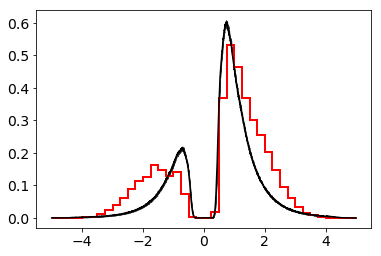

In [30]:
plot_rts_from_condition(dataf[dataf.condition == 'I1'][data.angle == 20].rt, pred_i1_avg_20, pred_i1_std_20)

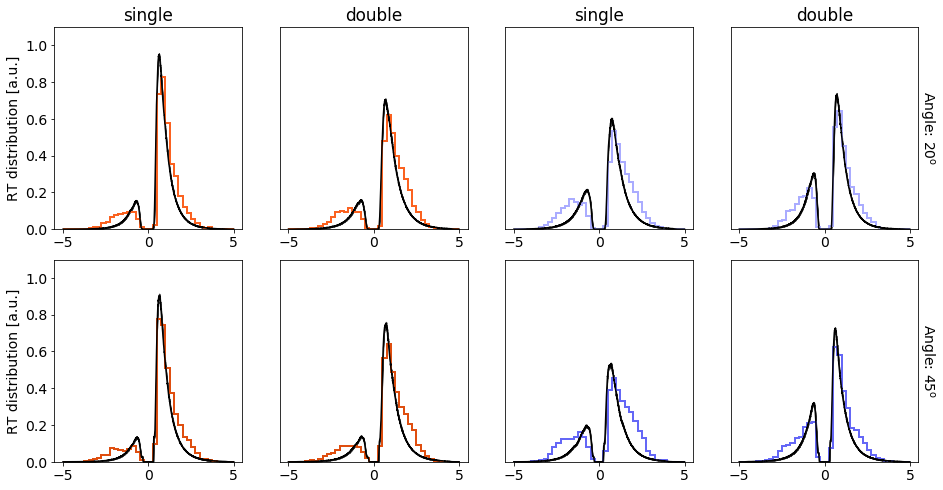

In [46]:
fig = plt.figure(figsize=(15, 8))
fig.subplots_adjust(left=0.1, right=0.9, hspace = 0.15)

plt.subplot(2,4,1)
plot_rts_from_condition(dataf[dataf.condition == 'C1'][dataf.angle == 20].rt, pred_c1_avg_20, pred_c1_std_20, color='#fb6220')
plt.ylim([0, 1.1])
plt.title('single')
plt.ylabel('RT distribution [a.u.]')

plt.subplot(2,4,2)
plot_rts_from_condition(dataf[dataf.condition == 'C2'][dataf.angle == 20].rt, pred_c2_avg_20, pred_c2_std_20, color='#fb6220')
plt.ylim([0, 1.1])
plt.yticks([])
plt.title('double')

plt.subplot(2,4,3)
plot_rts_from_condition(dataf[dataf.condition == 'I1'][dataf.angle == 20].rt, pred_i1_avg_20, pred_i1_std_20, color='#aaacff')
plt.ylim([0, 1.1])
plt.yticks([])
plt.title('single')

ax = plt.subplot(2,4,4)
ax.yaxis.set_label_position('right')
plot_rts_from_condition(dataf[dataf.condition == 'I2'][dataf.angle == 20].rt, pred_i2_avg_20, pred_i2_std_20, color='#aaacff')
plt.ylim([0, 1.1])
plt.yticks([])
plt.title('double')

ax.set_ylabel(r'Angle: 20$^\mathrm{o}$', rotation=270, verticalalignment='baseline')

plt.subplot(2,4,5)
plot_rts_from_condition(dataf[dataf.condition == 'C1'][dataf.angle == 45].rt, pred_c1_avg_45, pred_c1_std_45, color='#df4e0f')
plt.ylim([0, 1.1])
plt.ylabel('RT distribution [a.u.]')

plt.subplot(2,4,6)
plot_rts_from_condition(dataf[dataf.condition == 'C2'][dataf.angle == 45].rt, pred_c2_avg_45, pred_c2_std_45, color='#df4e0f')
plt.ylim([0, 1.1])
plt.yticks([])

plt.subplot(2,4,7)
plot_rts_from_condition(dataf[dataf.condition == 'I1'][dataf.angle == 45].rt, pred_i1_avg_45, pred_i1_std_45, color='#6467f6')
plt.ylim([0, 1.1])
plt.yticks([])

ax = plt.subplot(2,4,8)
ax.yaxis.set_label_position('right')
plot_rts_from_condition(dataf[dataf.condition == 'I2'][dataf.angle == 45].rt, pred_i2_avg_45, pred_i2_std_45, color='#6467f6')
plt.ylim([0, 1.1])
plt.yticks([])
ax.set_ylabel(r'Angle: 45$^\mathrm{o}$', rotation=270, verticalalignment='baseline')
plt.savefig('rts_plot.svg')

# Inference

In [33]:
plt.hist(v_C1_20.trace() - v_I2_20.trace())
plt.axvline(x = np.mean(v_C1_20.trace() - v_I2_20.trace()), color = 'r')

NameError: name 'v_C1_20' is not defined

In [19]:
print '---- v'
print "P_v(I1.20 > I2.20) = ", (v_I1_20.trace() > v_I2_20.trace()).mean()
print "P_v(C1.20 > I2.20) = ", (v_C1_20.trace() > v_I2_20.trace()).mean()
print "P_v(C2.20 > I2.20) = ", (v_C2_20.trace() > v_I2_20.trace()).mean()
print "P_v(C1.20 > I1.20) = ", (v_C1_20.trace() > v_I1_20.trace()).mean()
print "P_v(C2.20 > I1.20) = ", (v_C2_20.trace() > v_I1_20.trace()).mean()
print "P_v(C1.20 > C2.20) = ", (v_C1_20.trace() > v_C2_20.trace()).mean()

print '---- t'
print "P_t(I1.20 > I2.20) = ", (t_I1_20.trace() > t_I2_20.trace()).mean()
print "P_t(C1.20 > I2.20) = ", (t_C1_20.trace() > t_I2_20.trace()).mean()
print "P_t(C2.20 > I2.20) = ", (t_C2_20.trace() > t_I2_20.trace()).mean()
print "P_t(C1.20 > I1.20) = ", (t_C1_20.trace() > t_I1_20.trace()).mean()
print "P_t(C2.20 > I1.20) = ", (t_C2_20.trace() > t_I1_20.trace()).mean()
print "P_t(C1.20 > C2.20) = ", (t_C1_20.trace() > t_C2_20.trace()).mean()

print '---- a'
print "P_a(I1.20 > I2.20) = ", (a_I1_20.trace() > a_I2_20.trace()).mean()
print "P_a(C1.20 > I2.20) = ", (a_C1_20.trace() > a_I2_20.trace()).mean()
print "P_a(C2.20 > I2.20) = ", (a_C2_20.trace() > a_I2_20.trace()).mean()
print "P_a(C1.20 > I1.20) = ", (a_C1_20.trace() > a_I1_20.trace()).mean()
print "P_a(C2.20 > I1.20) = ", (a_C2_20.trace() > a_I1_20.trace()).mean()
print "P_a(C1.20 > C2.20) = ", (a_C1_20.trace() > a_C2_20.trace()).mean()


---- v
P_v(I1.20 > I2.20) =  0.6621333333333334
P_v(C1.20 > I2.20) =  1.0
P_v(C2.20 > I2.20) =  1.0
P_v(C1.20 > I1.20) =  1.0
P_v(C2.20 > I1.20) =  0.9993333333333333
P_v(C1.20 > C2.20) =  0.9989333333333333
---- t
P_t(I1.20 > I2.20) =  0.708
P_t(C1.20 > I2.20) =  0.1728
P_t(C2.20 > I2.20) =  0.24973333333333333
P_t(C1.20 > I1.20) =  0.06733333333333333
P_t(C2.20 > I1.20) =  0.1184
P_t(C1.20 > C2.20) =  0.3916
---- a
P_a(I1.20 > I2.20) =  0.9974666666666666
P_a(C1.20 > I2.20) =  0.9581333333333333
P_a(C2.20 > I2.20) =  0.9997333333333334
P_a(C1.20 > I1.20) =  0.11306666666666666
P_a(C2.20 > I1.20) =  0.7709333333333334
P_a(C1.20 > C2.20) =  0.0252


In [42]:
vals_ = v_I1_20.trace() - v_I2_20.trace()
print "Inc diff", (st.scoreatpercentile(vals_ , 5), st.scoreatpercentile(vals_ , 95))

Inc diff (-0.09014962866668655, 0.1530311361972352)


In [20]:
print '---- v'
print "P_v(I1.45 > I2.45) = ", (v_I1_45.trace() > v_I2_45.trace()).mean()
print "P_v(C1.45 > I2.45) = ", (v_C1_45.trace() > v_I2_45.trace()).mean()
print "P_v(C2.45 > I2.45) = ", (v_C2_45.trace() > v_I2_45.trace()).mean()
print "P_v(C1.45 > I1.45) = ", (v_C1_45.trace() > v_I1_45.trace()).mean()
print "P_v(C2.45 > I1.45) = ", (v_C2_45.trace() > v_I1_45.trace()).mean()
print "P_v(C1.45 > C2.45) = ", (v_C1_45.trace() > v_C2_45.trace()).mean()

print '---- t'
print "P_t(I1.45 > I2.45) = ", (t_I1_45.trace() > t_I2_45.trace()).mean()
print "P_t(C1.45 > I2.45) = ", (t_C1_45.trace() > t_I2_45.trace()).mean()
print "P_t(C2.45 > I2.45) = ", (t_C2_45.trace() > t_I2_45.trace()).mean()
print "P_t(C1.45 > I1.45) = ", (t_C1_45.trace() > t_I1_45.trace()).mean()
print "P_t(C2.45 > I1.45) = ", (t_C2_45.trace() > t_I1_45.trace()).mean()
print "P_t(C1.45 > C2.45) = ", (t_C1_45.trace() > t_C2_45.trace()).mean()

print '---- a'
print "P_a(I1.45 > I2.45) = ", (a_I1_45.trace() > a_I2_45.trace()).mean()
print "P_a(C1.45 > I2.45) = ", (a_C1_45.trace() > a_I2_45.trace()).mean()
print "P_a(C2.45 > I2.45) = ", (a_C2_45.trace() > a_I2_45.trace()).mean()
print "P_a(C1.45 > I1.45) = ", (a_C1_45.trace() > a_I1_45.trace()).mean()
print "P_a(C2.45 > I1.45) = ", (a_C2_45.trace() > a_I1_45.trace()).mean()
print "P_a(C1.45 > C2.45) = ", (a_C1_45.trace() > a_C2_45.trace()).mean()


---- v
P_v(I1.45 > I2.45) =  0.6714666666666667
P_v(C1.45 > I2.45) =  1.0
P_v(C2.45 > I2.45) =  1.0
P_v(C1.45 > I1.45) =  1.0
P_v(C2.45 > I1.45) =  1.0
P_v(C1.45 > C2.45) =  0.9889333333333333
---- t
P_t(I1.45 > I2.45) =  0.7437333333333334
P_t(C1.45 > I2.45) =  0.3393333333333333
P_t(C2.45 > I2.45) =  0.4016
P_t(C1.45 > I1.45) =  0.14546666666666666
P_t(C2.45 > I1.45) =  0.186
P_t(C1.45 > C2.45) =  0.43066666666666664
---- a
P_a(I1.45 > I2.45) =  0.9981333333333333
P_a(C1.45 > I2.45) =  0.9836
P_a(C2.45 > I2.45) =  0.9994666666666666
P_a(C1.45 > I1.45) =  0.23266666666666666
P_a(C2.45 > I1.45) =  0.7341333333333333
P_a(C1.45 > C2.45) =  0.08706666666666667
